In [2]:
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn import preprocessing
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split

In [3]:
df = pd.read_csv("Brownlow Full Database.csv")

def calculate_margin(row):
    if(row['Team'] == row['Home_Team']):
        return row['Home_Score'] - row['Away_Score']
    else:
        return row['Away_Score'] - row['Home_Score']
    
    
df = df.iloc[:, :-4]
df['Winning_Margin'] = df.apply(lambda x: calculate_margin(x), axis=1)
df = df.iloc[:, 10:]

In [4]:
def sample_no_votes(row):
    if row['Brownlow_Votes'] > 0:
        return True
    else:
        return True if random.randint(0, 100) < 10 else False


In [5]:
df['keep'] = df.apply(lambda x: sample_no_votes(x), axis=1)
df_balanced = df.drop(df[df.keep == False].index)

In [6]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [7]:
X = df_balanced.drop([
    'Contested_Possessions', # values not recorded in 2012 data
    'Uncontested_Possessions', # values not recorded in 2012 data
    'Brownlow_Votes',
    'keep'
], axis=1).values

y = df_balanced['Brownlow_Votes'].fillna(0).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = preprocessing.StandardScaler().fit(X_train)
scaler.transform(X_train)
scaler.transform(X_test)

array([[ 0.04338463, -1.10976999, -0.65341738, ...,  1.01340567,
         0.53278193,  1.12858068],
       [ 0.6010132 , -0.0151773 ,  0.35368898, ...,  0.49847209,
         1.13518997,  1.35012309],
       [ 0.97276557, -0.74490576,  0.12988757, ..., -0.01646148,
         1.34603279, -0.28929076],
       ...,
       [-0.70012012, -0.0151773 , -0.42961596, ...,  0.32682757,
        -0.52143215, -1.21976889],
       [-1.25774868, -0.92733787, -1.32482161, ..., -3.53517423,
        -1.63588704,  1.5716655 ],
       [-1.0718725 , -0.92733787, -1.21292091, ...,  0.67011662,
        -1.36480342,  0.19810255]])

The optimal number of neighbors is 39


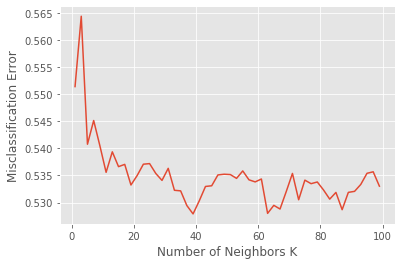

In [8]:
# creating odd list of K for KNN
neighbors = list(range(1, 100, 2))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='balanced_accuracy')
    cv_scores.append(scores.mean())
    
    
# changing to misclassification error
mse = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[mse.index(min(mse))]
print("The optimal number of neighbors is {}".format(optimal_k))

# plot misclassification error vs k
plt.plot(neighbors, mse)
plt.xlabel("Number of Neighbors K")
plt.ylabel("Misclassification Error")
plt.show()

Normalized confusion matrix
[[0.93994778 0.03133159 0.01914708 0.00957354]
 [0.38162544 0.204947   0.20848057 0.204947  ]
 [0.27203065 0.18390805 0.21455939 0.32950192]
 [0.15686275 0.11372549 0.25882353 0.47058824]]


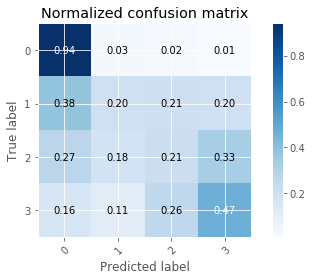

In [9]:
# instantiate learning model (k = 3)
knn = KNeighborsClassifier(n_neighbors=39)

# fitting the model
knn.fit(X_train, y_train)

# predict the response
pred = knn.predict(X_test)


plot_confusion_matrix(y_test, pred, classes=['0','1','2','3'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [11]:
df2019 = pd.read_csv("2019 Brownlow Match Data.csv")
df2019 = df2019.iloc[:, :-4]
df2019['Winning_Margin'] = df2019.apply(lambda x: calculate_margin(x), axis=1)
df2019 = df2019.iloc[:, 10:]
df2019.shape

X = df2019.drop([
    'Contested_Possessions', # values not recorded in 2012 data
    'Uncontested_Possessions' # values not recorded in 2012 data
], axis=1).values

scaler.transform(X)

array([[ 0.78688939,  0.71455115,  0.91319252, ...,  0.32682757,
         0.26169831, -0.97607224],
       [ 0.04338463, -0.56247364, -0.31771526, ...,  0.15518305,
        -0.22022813, -0.97607224],
       [ 1.71627033, -0.74490576,  0.5774904 , ...,  0.06936078,
         0.80386555, -0.97607224],
       ...,
       [-0.88599631, -0.92733787, -1.1010202 , ...,  0.41264983,
        -0.94311779, -1.24192313],
       [-1.44362487, -0.74490576, -1.32482161, ..., -0.10228374,
        -1.48528503, -1.24192313],
       [ 0.41513701,  0.89698327,  0.80129181, ..., -0.53139505,
         0.32193911, -1.24192313]])

In [12]:
probs = knn.predict_proba(X)
hard_pred = knn.predict(X)

In [13]:
df2019_predictions = pd.read_csv("2019 Brownlow Match Data.csv")
df2019_predictions['Predicted_Votes'] = hard_pred.tolist()

In [14]:
# Group by player and sort form high votes to low
results = pd.DataFrame(data = df2019_predictions.groupby(['Year','player_name','Team'])['Predicted_Votes'].sum())
results = results.reset_index()
results = results.sort_values('Predicted_Votes', ascending=False);

# Display the top 20 predicted vote getters for 2016
results.head(n=20)

,Year,player_name,Team,Predicted_Votes
242,2019,Jack Macrae,WB,35.0
348,2019,Josh Dunkley,WB,33.0
9,2019,Adam Treloar,COLL,31.0
60,2019,Brad Crouch,ADEL,31.0
494,2019,Patrick Dangerfield,GEEL,30.0
461,2019,Nat Fyfe,FRE,29.0
420,2019,Marcus Bontempelli,WB,27.0
167,2019,Dayne Zorko,BL,26.0
432,2019,Matt Crouch,ADEL,26.0
382,2019,Lachie Neale,BL,26.0


In [15]:
df2019_predictions['prediction0'] = probs[:,0] # Probably not needed
df2019_predictions['prediction1'] = probs[:,1]
df2019_predictions['prediction2'] = probs[:,2]
df2019_predictions['prediction3'] = probs[:,3]

In [16]:
df2019_predictions.head()

,Unique_Game_ID,Year,Round,game_id,Home_Team,Home_Score,Away_Team,Away_Score,player_name,Team,...,AFL_Fantasy_Points,Champion_Data_Rating,Tackles_50,Metres_Gained,Score_Involvements,Predicted_Votes,prediction0,prediction1,prediction2,prediction3
0,1387,2019,1,1,CARL,64,RICH,97,Marc Murphy,CARL,...,97,14.9,0,530,7,0.0,0.666667,0.205128,0.128205,0.000000
1,1387,2019,1,1,CARL,64,RICH,97,Sam Petrevski-Seton,CARL,...,81,7.1,0,282,0,0.0,1.000000,0.000000,0.000000,0.000000
2,1387,2019,1,1,CARL,64,RICH,97,Nic Newman,CARL,...,115,15.9,0,584,4,0.0,0.384615,0.358974,0.205128,0.051282
3,1387,2019,1,1,CARL,64,RICH,97,Liam Jones,CARL,...,49,11.5,0,20,1,0.0,1.000000,0.000000,0.000000,0.000000
4,1387,2019,1,1,CARL,64,RICH,97,Andrew Phillips,CARL,...,83,9.7,2,163,2,0.0,1.000000,0.000000,0.000000,0.000000


In [17]:
df2019_predictions.to_csv('2019KNNClassificationPreProccessed.csv')